<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Combining-Mask-Image-with-DS" data-toc-modified-id="Combining-Mask-Image-with-DS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Combining Mask Image with DS</a></span></li><li><span><a href="#Finish-up-the-mask-and-invert-it" data-toc-modified-id="Finish-up-the-mask-and-invert-it-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Finish up the mask and invert it</a></span></li></ul></div>

# Data Loading 

In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import sys, os
import numpy as np
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
import os
import pickle as pkl
from skimage import morphology


In [2]:
full_data_dir = '/pghbio/dbmi/batmanlab/Data/MRE/'
subjects = sorted([x for x in os.listdir(full_data_dir) if x.isdigit()])
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
sequence_labels = ['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast']
extras = ['extra0', 'extra1', 'extra2', 'extra3']

In [3]:
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_1.p', 'rb'))

# Enhancing Mask 

In [4]:
da_msk = ds.sel(sequence='elast', z=1, subject='365').image.values - ds.sel(sequence='elastMsk', z=1, subject='365').image.values
da_msk_hc = np.where(da_msk>1e-7,1,0)

Text(0.5,1,'mask, high contrast')

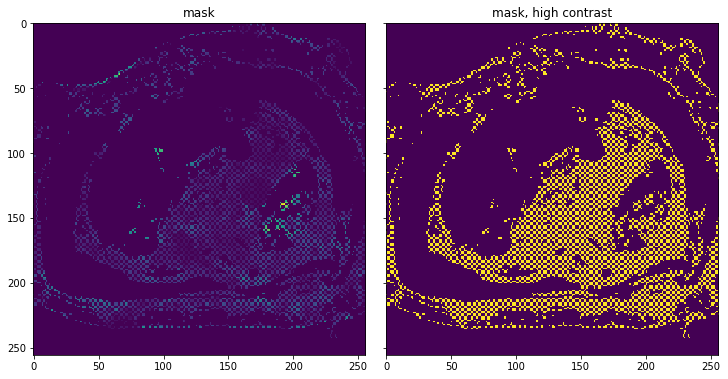

In [18]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,6), sharex=True, sharey=True)
axs[0].imshow(da_msk)
axs[0].set_title('mask')
axs[1].imshow(da_msk_hc)
axs[1].set_title('mask, high contrast')

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


Text(0.5,1,'binary dilation, remove small holes')

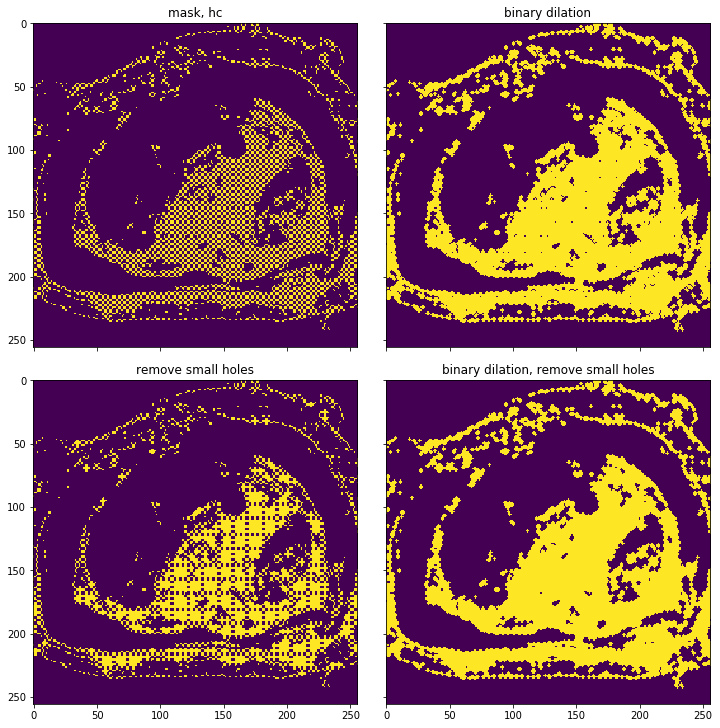

In [19]:
from skimage import morphology

bd = morphology.binary_dilation(da_msk_hc)
rsh = morphology.remove_small_holes(da_msk_hc, 5, connectivity=1)
bd_rsh = morphology.remove_small_holes(bd, 2, connectivity=1) 
#bd_rsh = morphology.binary_dilation(rsh) 
seed = da_msk_hc.copy()
seed[1:-1, 1:-1] = da_msk_hc.max()
ero = morphology.reconstruction(seed, da_msk_hc, method='erosion')
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10), sharex=True, sharey=True, squeeze=True)
axs = axs.flatten()
axs[0].imshow(da_msk_hc)
axs[0].set_title('mask, hc')
axs[1].imshow(bd)
axs[1].set_title('binary dilation')
axs[2].imshow(rsh)
axs[2].set_title('remove small holes')
axs[3].imshow(bd_rsh)
axs[3].set_title('binary dilation, remove small holes')


## Combining Mask Image with DS

In [20]:
for sub in list(ds.subject):
    for z in list(ds.z):
        msk = ds.sel(sequence='elast', z=z, subject=sub).image.values - ds.sel(sequence='elastMsk', z=z, subject=sub).image.values 
        msk = np.where(msk>1e-7,1,0)
        msk = morphology.binary_dilation(msk)
        ds['image'].loc[dict(sequence='extra0', z=z, subject=sub)] = msk

new_sequence = [a.replace('extra0', 'msk') for a in ds.sequence.values]
print(new_sequence)
ds = ds.assign_coords(sequence = new_sequence)


['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast', 'msk', 'extra1', 'extra2', 'extra3']


In [21]:
ds.sequence

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast', 'msk', 'extra1',
       'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T2SS' 'T1Pre' 'T1Pos' ... 'extra2' 'extra3'

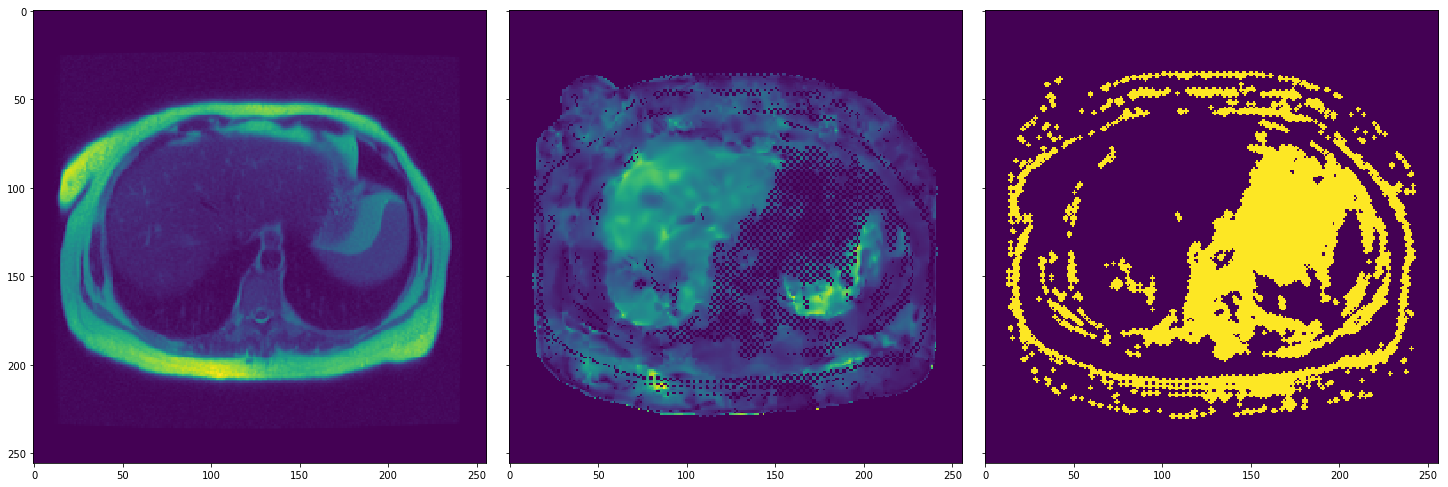

In [22]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(20,10), sharex=True, sharey=True)
axs = axs.flatten()
subj = '405'
z = 2
axs[0].imshow(ds.sel(subject=subj, sequence='T1Pos', z=z).image)
axs[1].imshow(ds.sel(subject=subj, sequence='elastMsk', z=z).image)
#axs[2].imshow(msk)
axs[2].imshow(ds.sel(subject=subj, sequence='msk', z=z).image)


## Finish up the mask and invert it

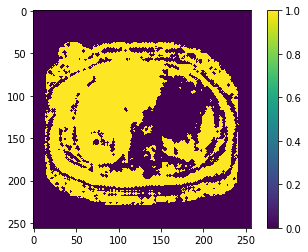

In [23]:
elast = ds.sel(sequence='elast', z=2, subject='405').image.values
msk = ds.sel(sequence='msk', z=2, subject='405').image.values
msk = msk+np.where(elast<1e-8,1,0)
msk = np.where(msk>1,1,msk)
plt.imshow(1-msk)
plt.colorbar()
        
        #ds['images'].loc[dict(sequence='msk', slices=sli, subject=sub)] = (msk)

In [5]:
for sub in list(ds.subject):
    for sli in list(ds.z):
        elast = ds.sel(sequence='elast', z=sli, subject=sub).image.values
        msk = ds.sel(sequence='msk', z=sli, subject=sub).image.values 
        msk = msk+np.where(elast<1e-8,1,0)
        msk = 1-np.where(msk>1,1,msk)
        ds['image'].loc[dict(sequence='msk', z=sli, subject=sub)] = msk

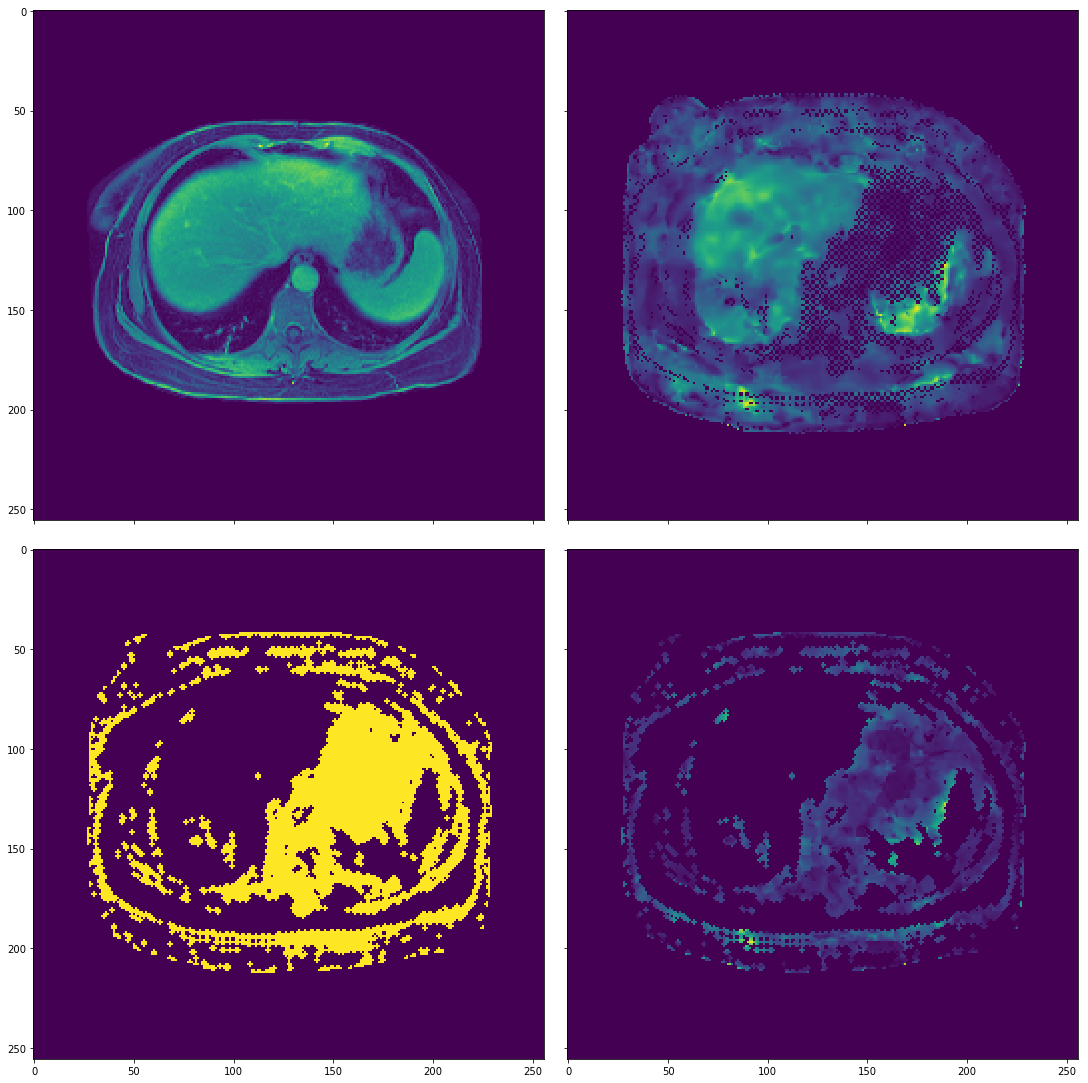

In [6]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(15,15), sharex=True, sharey=True)
axs = axs.flatten()
subj = '405'
slc = 2
axs[0].imshow(ds.sel(subject=subj, sequence='T1Pos', z=slc).image)
axs[1].imshow(ds.sel(subject=subj, sequence='elastMsk', z=slc).image)
#axs[2].imshow(msk)
axs[2].imshow(ds.sel(subject=subj, sequence='msk', z=slc).image)
axs[3].imshow(ds.sel(subject=subj, sequence='msk', z=slc).image*ds.sel(subject=subj, sequence='elast', z=slc).image)

In [7]:
pkl.dump(ds, open(full_data_dir+'mre_ds_preprocess_2.p', 'wb'), protocol=-1)